# 삼성 DS-KAIST AI Expert 프로그램
## Week 4: Multitask Learning

실습 일시: 2019년 7월 23일 (화), 13:30 - 17:30

담당 조교: 이한국 (hankook.lee@kaist.ac.kr)

# Section 0. Introduction

본 실습에서는 TensorFlow와 Keras 프레임워크를 이용하여, multi-task learning에 관한 실습을 진행할 것입니다. multi-task learning은 여러가지 테스크를 동시에 학습함으로써 공통된 유용한 feature를 효과적으로 배우는 방법으로, 어떤 효과가 있는지 알아볼 예정입니다.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

### Hyperparamters

아래는 이번 실습에서 사용할 hyperparameter들을 사전 정의해 둔 것입니다.

In [3]:
batch_size = 128
steps_per_epoch = 300
num_epochs = 10

# Section 1. Load Dataset (CIFAR-10, CIFAR-100)

이번 실습에서 사용할 dataset은 CIFAR-10과 CIFAR-100 입니다. 각 dataset은 총 50000개의 training image를 가지고 있고, 10000개의 test image를 가지고 있습니다. 또한, CIFAR-10의 이미지는 10개의 class중 하나에 속하고, CIFAR-100의 이미지는 100개의 class중 하나에 속하게 됩니다.

In [4]:
cifar10 = tf.keras.datasets.cifar10
cifar100 = tf.keras.datasets.cifar100

In [5]:
(x_train_c10, y_train_c10), (x_test_c10, y_test_c10) = cifar10.load_data()
(x_train_c100, y_train_c100), (x_test_c100, y_test_c100) = cifar100.load_data()

In [6]:
print('CIFAR-10 ------')
print('트레이닝 샘플 수: %d' % x_train_c10.shape[0])
print('이미지 크기: %d x %d x %d' % (x_train_c10.shape[1], x_train_c10.shape[2], x_train_c10.shape[3]))
print('트레이닝 데이터 크기: %d x %d x %d x %d' % (*x_train_c10.shape, ))
print('')
print('CIFAR-100 ------')
print('트레이닝 샘플 수: %d' % x_train_c100.shape[0])
print('이미지 크기: %d x %d x %d' % (x_train_c100.shape[1], x_train_c100.shape[2], x_train_c100.shape[3]))
print('트레이닝 데이터 크기: %d x %d x %d x %d' % (*x_train_c100.shape, ))

CIFAR-10 ------
트레이닝 샘플 수: 50000
이미지 크기: 32 x 32 x 3
트레이닝 데이터 크기: 50000 x 32 x 32 x 3

CIFAR-100 ------
트레이닝 샘플 수: 50000
이미지 크기: 32 x 32 x 3
트레이닝 데이터 크기: 50000 x 32 x 32 x 3


### Preprocessing Data
Image의 pixel 의 값은 (R, G, B) 형태로 표현되고, 각 channel (R/G/B) 마다 [0, 1, 2, ..., 255] 의 정수 값을 가집니다. 일반적으로 neural network를 학습할 때에는 normalized 되어있는 값을 input으로 사용하는 것이 좋습니다. 따라서, 각 image 값들을 [0, 1/255, ..., 1.0] 의 실수 값으로 치환해줍니다.
Image의 label 은 [0, 1, 2, ..., 9] 의 값을 가집니다. 이러한 label 정보는 일반적으로 one-hot encoding으로 바꿔주어 사용합니다. one-hot encoding을 하게 되면 label 0은 [1, 0, 0, ..., 0], label 1은 [0, 1, 0, ..., 0], 그리고 label 9는 [0, 0, 0, ..., 1]으로 바뀌게 됩니다.

In [7]:
x_train_c10 = x_train_c10 / 255.0
x_test_c10 = x_test_c10 / 255.0

y_train_c10 = tf.keras.utils.to_categorical(y_train_c10, 10)
y_test_c10 = tf.keras.utils.to_categorical(y_test_c10, 10)

In [8]:
x_train_c100 = x_train_c100 / 255.0
x_test_c100 = x_test_c100 / 255.0

y_train_c100 = tf.keras.utils.to_categorical(y_train_c100, 100)
y_test_c100 = tf.keras.utils.to_categorical(y_test_c100, 100)

### Data Generator

`ImageDataGenerator`는 Keras에 있는 API 중 하나로, data augmentation (좌우 반전 등) 을 손쉽게 할 수 있습니다. 가능한 data augmentation 방법들은 내용은 https://keras.io/preprocessing/image/ 에서 확인하실 수 있습니다. 이번 실습에서는 일반적으로 CIFAR dataset에서 사용하는 random 상하좌우 shift와 좌우 반전을 사용할 것입니다.

In [9]:
datagen_c10 = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=5,
    height_shift_range=5,
    fill_mode='constant',
    horizontal_flip=True).flow(x_train_c10, y_train_c10, batch_size=batch_size)

In [10]:
datagen_c100 = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=5,
    height_shift_range=5,
    fill_mode='constant',
    horizontal_flip=True).flow(x_train_c100, y_train_c100, batch_size=batch_size)

Test data를 위한 DataGenerator를 만들기 위해 아래의 함수를 선언하였습니다. Batch를 앞에서부터 100개씩 구성합니다.

In [11]:
def test_datagen(x, y):
    assert x.shape[0] == 10000
    assert y.shape[0] == 10000
    while True:
        for i in range(0, 10000, 100):
            yield x[i:i+100], y[i:i+100]

In [12]:
test_datagen_c10 = test_datagen(x_test_c10, y_test_c10)
test_datagen_c100 = test_datagen(x_test_c100, y_test_c100)

Multi-task learning을 위해서는, 2개의 data generator를 하나의 data generator로 합쳐줘야합니다. 아래의 함수를 통해 두개의 generator를 합칠 수 있습니다.

In [13]:
def merge_datagen(datagen1, datagen2):
    while True:
        x1, y1 = next(datagen1)
        x2, y2 = next(datagen2)
        yield [x1, x2], [y1, y2]

In [14]:
datagen = merge_datagen(datagen_c10, datagen_c100)
test_datagen = merge_datagen(test_datagen_c10, test_datagen_c100)

### Plotting Images

아래의 script를 이용하여 각 데이터셋에 어떤 이미지들이 들어있는지 확인할 수 있습니다.

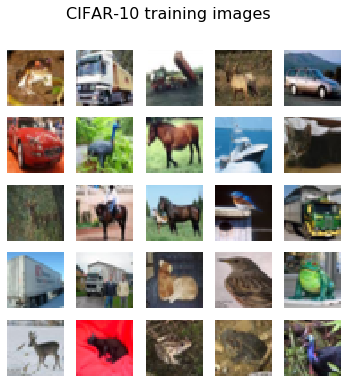

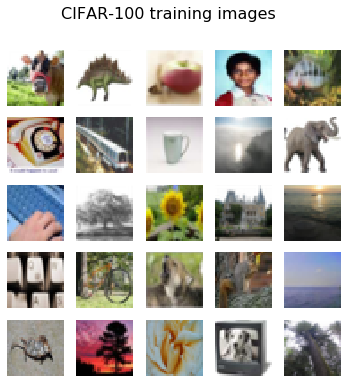

In [15]:
plt.figure(figsize=(6,6))
plt.suptitle('CIFAR-10 training images', fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train_c10[i])
    plt.axis('off')
    
plt.figure(figsize=(6,6))
plt.suptitle('CIFAR-100 training images', fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train_c100[i])
    plt.axis('off')

# Section 2. Multi-task Learning using Keras

이번 실습에서는 간단한 6-layer CNN을 사용할 것입니다. multi-task learning을 위해서, 2 종류의 inputs을 받고, 2 종류의 outputs을 출력하는 형태로 network를 design할 것입니다.

`build_shared_conv_block`은 convolutional layer와, batch normalization layer, 그리고 relu activation으로 구성된 하나의 convolutional block입니다.
두 개의 입력값 `inputs1`, `inputs2` 은 같은 layer를 공유해야하기 때문에, Keras API로 먼저 layer을 선언하고, 선언된 layer를 이용하여 출력값을 구해줍니다.

In [16]:
def build_shared_conv_block(inputs1, inputs2, num_channels):
    # define layers
    conv = Conv2D(num_channels, (3, 3), padding='same')
    bn = BatchNormalization()
    relu = Activation('relu')
    
    # compute outputs
    outputs1 = relu(bn(conv(inputs1)))
    outputs2 = relu(bn(conv(inputs2)))
    return outputs1, outputs2

`build_network`는 multi-task를 다룰 수 있는 하나의 CNN을 만드는 역할을 합니다. 이 함수는 `inputs1`, `inputs2`, `num_classes1`, `num_classes2`, `base_width` 다섯 개의 인자를 받습니다.
- `inputs1`, `inputs2`: 각 task의 input을 의미합니다.
- `num_classes1`, `num_classes2`: 각 task의 output dimension을 의미합니다. CIFAR-10, CIFAR-100을 사용할 것이므로, 10 / 100 이 됩니다.
- `base_width`: network의 width를 나타내는 역할을 합니다. teacher model로 wide한 모델을 사용할 것이고, student 모델로는 thin한 모델을 사용할 예정입니다.

`build_network`는 총 2개의 tensor를 return합니다.
- `outputs1`, `outputs2`: network의 최종 출력값으로, 각 task에 대한 output을 의미합니다.

## Q1. Build Separated Dense Layers (20 min)

아래의 코드에서 `x1, x2`는 layer를 공유하는 형태로 계산된 feature입니다. 여기서 `Dense` layer를 이용하되, 하나의 task 마다 하나의 `Dense` layer가 생기도록 구현해보세요.
각 `Dense` layer의 output dimension은 `num_classes1`과 `num_classes2`가 되어야 합니다. 비슷하게, Softmax activation도 구현하세요.

Transfer learning 실습 코드를 참고하면 좋습니다.

In [17]:
def build_network(inputs1, inputs2, num_classes1=10, num_classes2=100, base_width=16):
    x1, x2 = build_shared_conv_block(inputs1, inputs2, base_width)
    x1, x2 = build_shared_conv_block(x1, x2, base_width)
    
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
    x1, x2 = pool1(x1), pool1(x2)
    x1, x2 = build_shared_conv_block(x1, x2, base_width*2)
    x1, x2 = build_shared_conv_block(x1, x2, base_width*2)

    pool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
    x1, x2 = pool2(x1), pool2(x2)
    x1, x2 = build_shared_conv_block(x1, x2, base_width*4)
    x1, x2 = build_shared_conv_block(x1, x2, base_width*4)

    pool3 = GlobalAveragePooling2D()
    x1, x2 = pool3(x1), pool3(x2)
    
    # Q1. Separated Dense layers
    logits1 = Dense(num_classes1)(x1)
    logits2 = Dense(num_classes2)(x2)

    outputs1 = Activation('softmax', name='outputs1')(logits1)
    outputs2 = Activation('softmax', name='outputs2')(logits2)
    
    return outputs1, outputs2

In [18]:
inputs1 = Input(shape=(32, 32, 3), name='inputs1')
inputs2 = Input(shape=(32, 32, 3), name='inputs2')

## Define Model

먼저, `base_width=16`인 network를 정의합니다. 이 모델은 inputs이 2개, outputs이 2개인 모델입니다.

In [19]:
outputs1, outputs2 = build_network(inputs1, inputs2, base_width=8)
model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=[outputs1, outputs2], name='model')
model.summary()

W0729 22:49:28.499915 12908 deprecation.py:506] From C:\Users\home0194\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
inputs2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 8)    224         inputs1[0][0]                    
                                                                 inputs2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 8)    32          conv2d[0][0]                 

아래 함수 `plot_history`는 training curve를 시각화하는 함수입니다. 학습 후 성능이 어떻게 변화하는지 관측해볼 것입니다.

In [20]:
def plot_history(history):
    epochs = len(history.history['loss'])
    plt.figure(figsize=(20, 3))

    plt.subplot(1, 4, 1)
    plt.title('loss')
    plt.plot(range(epochs), history.history['outputs1_loss'], 'r')
    plt.plot(range(epochs), history.history['val_outputs1_loss'], 'b')
    plt.legend(['train', 'val'])

    plt.subplot(1, 4, 2)
    plt.title('accuracy')
    plt.plot(range(epochs), history.history['outputs1_acc'], 'r--')
    plt.plot(range(epochs), history.history['val_outputs1_acc'], 'b--')    
    plt.legend(['train', 'val'])

    plt.subplot(1, 4, 3)
    plt.title('loss')
    plt.plot(range(epochs), history.history['outputs2_loss'], 'r')
    plt.plot(range(epochs), history.history['val_outputs2_loss'], 'b')
    plt.legend(['train', 'val'])

    plt.subplot(1, 4, 4)
    plt.title('accuracy')
    plt.plot(range(epochs), history.history['outputs2_acc'], 'r--')
    plt.plot(range(epochs), history.history['val_outputs2_acc'], 'b--')    
    plt.legend(['train', 'val'])

    print('CIFAR10  최대 도달 성능: %.2f%%' % (max(history.history['val_outputs1_acc'])*100,))
    print('CIFAR100 최대 도달 성능: %.2f%%' % (max(history.history['val_outputs2_acc'])*100,))

## Train Model on CIFAR-10 & CIFAR-100

두 가지 데이터를 동시에 학습해야 하므로, 다음과 같이 compile해줍니다.

In [21]:
model.compile(optimizer='adam',
              loss=['categorical_crossentropy', 'categorical_crossentropy'], # output이 2개이기 때문에 각각에 대해 loss를 지정해주어야 합니다.
              metrics=['accuracy', 'accuracy']) # output이 2개이기 때문에 각각에 대해 metric을 지정해주어야 합니다.

그리고 Model의 `fit_generator`를 사용하여 네트워크를 학습해줍니다. 여기서 `generator`는 위에서 선언한 data augmentation이 된 dataset으로 생각할 수 있습니다. `steps_per_epoch`은 한 epoch마다 iteration 수를, `epochs`는 총 epoch을 나타냅니다.

In [22]:
history = model.fit_generator(datagen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              validation_data=test_datagen,
                              validation_steps=100, verbose=1)

Epoch 1/10
300/300 [==============================] - 222s 740ms/step - loss: 6.0748 - outputs1_loss: 1.7421 - outputs2_loss: 4.3327 - outputs1_acc: 0.3679 - outputs2_acc: 0.0509 - val_loss: 5.6253 - val_outputs1_loss: 1.5572 - val_outputs2_loss: 4.0682 - val_outputs1_acc: 0.4165 - val_outputs2_acc: 0.0780
Epoch 2/10
300/300 [==============================] - 211s 704ms/step - loss: 5.2927 - outputs1_loss: 1.4247 - outputs2_loss: 3.8679 - outputs1_acc: 0.4822 - outputs2_acc: 0.1074 - val_loss: 5.2664 - val_outputs1_loss: 1.4672 - val_outputs2_loss: 3.7992 - val_outputs1_acc: 0.4675 - val_outputs2_acc: 0.1019
Epoch 3/10
300/300 [==============================] - 212s 706ms/step - loss: 4.9169 - outputs1_loss: 1.3020 - outputs2_loss: 3.6149 - outputs1_acc: 0.5292 - outputs2_acc: 0.1433 - val_loss: 4.9284 - val_outputs1_loss: 1.2861 - val_outputs2_loss: 3.6423 - val_outputs1_acc: 0.5297 - val_outputs2_acc: 0.1188
Epoch 4/10
300/300 [==============================] - 215s 717ms/step - loss

위에서 선언한 `plot_history` 함수를 이용하여 학습이 어떻게 되었는지 확인해봅니다.

CIFAR10  최대 도달 성능: 63.43%
CIFAR100 최대 도달 성능: 23.41%


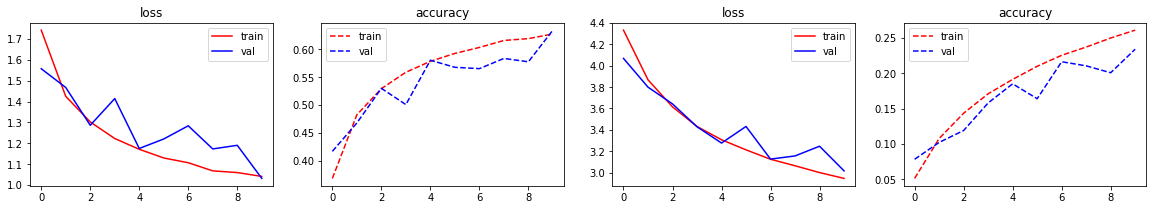

In [23]:
plot_history(history)

위에서 정의한 모델은 앞의 transfer learning에서 사용한 student model과 같은 크기의 모델입니다. cifar10에서와 cifar100에서의 모델 성능을 확인해보세요. 하나의 모델만 사용했음에도, 두가지 테스크에서 어느정도 성능을 보여줍니다.

## Q2. BN layers를 분리하기 (40 min)

아래의 두 함수를 수정하여, BN layer가 각 task별로 따로 사용될 수 있도록 분리해보세요.

In [24]:
def build_shared_conv_block(inputs1, inputs2, num_channels):
    # Q2. 이 함수를 수정하세요!
    
    # define layers
    conv = Conv2D(num_channels, (3, 3), padding='same')
    bn1 = BatchNormalization(inputs1)
    bn2 = BatchNormalization(inputs2)
    relu = Activation('relu')
    
    # compute outputs
    outputs1 = relu(bn1(conv(inputs1)))
    outputs2 = relu(bn2(conv(inputs2)))
    return outputs1, outputs2

이전 실습과 위의 코드를 바탕으로, `model`을 다시 build(`build_network` 이용)하고, compile한 뒤, 학습을 다시 해보세요

In [25]:
# Q2. build network
def build_network(inputs1, inputs2, num_classes1=10, num_classes2=100, base_width=16):
    x1, x2 = build_shared_conv_block(inputs1, inputs2, base_width)
    x1, x2 = build_shared_conv_block(x1, x2, base_width)
    
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
    x1, x2 = pool1(x1), pool1(x2)
    x1, x2 = build_shared_conv_block(x1, x2, base_width*2)
    x1, x2 = build_shared_conv_block(x1, x2, base_width*2)

    pool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
    x1, x2 = pool2(x1), pool2(x2)
    x1, x2 = build_shared_conv_block(x1, x2, base_width*4)
    x1, x2 = build_shared_conv_block(x1, x2, base_width*4)

    pool3 = GlobalAveragePooling2D()
    x1, x2 = pool3(x1), pool3(x2)
    
    # Q1. Separated Dense layers
    logits1 = Dense(num_classes1)(x1)
    logits2 = Dense(num_classes2)(x2)

    outputs1 = Activation('softmax', name='outputs1')(logits1)
    outputs2 = Activation('softmax', name='outputs2')(logits2)
    
    return outputs1, outputs2

In [26]:
# Q2: model compile
model.compile(optimizer='adam',
              loss=['categorical_crossentropy', 'categorical_crossentropy'], # output이 2개이기 때문에 각각에 대해 loss를 지정해주어야 합니다.
              metrics=['accuracy', 'accuracy']) # output이 2개이기 때문에 각각에 대해 metric을 지정해주어야 합니다.

Epoch 1/10
300/300 [==============================] - 218s 727ms/step - loss: 3.9305 - outputs1_loss: 1.0248 - outputs2_loss: 2.9057 - outputs1_acc: 0.6305 - outputs2_acc: 0.2665 - val_loss: 3.9667 - val_outputs1_loss: 1.0519 - val_outputs2_loss: 2.9148 - val_outputs1_acc: 0.6197 - val_outputs2_acc: 0.2575
Epoch 2/10
300/300 [==============================] - 205s 685ms/step - loss: 3.8710 - outputs1_loss: 1.0122 - outputs2_loss: 2.8588 - outputs1_acc: 0.6373 - outputs2_acc: 0.2737 - val_loss: 4.1515 - val_outputs1_loss: 1.1738 - val_outputs2_loss: 2.9777 - val_outputs1_acc: 0.5944 - val_outputs2_acc: 0.2408
Epoch 3/10
300/300 [==============================] - 206s 688ms/step - loss: 3.8372 - outputs1_loss: 1.0059 - outputs2_loss: 2.8313 - outputs1_acc: 0.6380 - outputs2_acc: 0.2805 - val_loss: 4.0553 - val_outputs1_loss: 1.1968 - val_outputs2_loss: 2.8585 - val_outputs1_acc: 0.5859 - val_outputs2_acc: 0.2606
Epoch 4/10
300/300 [==============================] - 193s 644ms/step - loss

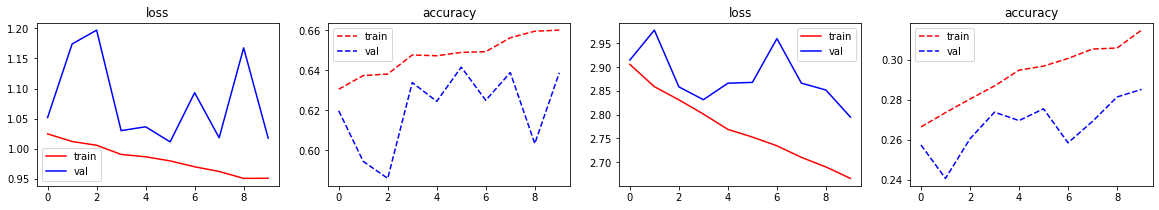

In [27]:
# Q2: train model & training curve visualization
history = model.fit_generator(datagen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              validation_data=test_datagen,
                              validation_steps=100, verbose=1)

plot_history(history)

## Assignment 2: 최적의 구조 찾기

- 앞 실습에서는 마지막 output layer와 BN layer를 각 task별로 분리하고, 나머지 convolutional layer는 task에 상관없이 공유하도록 디자인하였습니다.
- 하지만 task에 따라서 일부 convolutional layer를 분리시키는게 나을 수도 있습니다. 예를 들어, low-level convolutional layer는 공유하지만, high-level convolutional layer는 공유하지 않도록 할 수도 있습니다.
- 이번 실습에서는 다양한 형태로 모델을 분리/공유시켜보면서 성능이 어떻게 변하는지 확인해보세요. 좋은 구조를 찾은 분께는 가산점을 드릴 예정입니다.
- **제출은 README.md 파일을 참고하세요.**

In [31]:
def build_shared_conv_block1(inputs1, inputs2, num_channels):
    # A2. 자신만의 공유/분리 구조를 만들어보세요
    # => More Modifiy
    
    # define layers
    conv = Conv2D(num_channels, (3, 3), padding='same')
    bn1 = BatchNormalization(inputs1)
    bn2 = BatchNormalization(inputs2)
    relu = Activation('relu')
    
    # compute outputs
    outputs1 = relu(bn1(conv(inputs1)))
    outputs2 = relu(bn2(conv(inputs2)))
    
    return outputs1, outputs2

In [32]:
def build_shared_conv_block2(inputs1, inputs2, num_channels):
    # A2. 자신만의 공유/분리 구조를 만들어보세요
    # => More Modifiy
    
    # define layers
    conv = Conv2D(num_channels, (3, 3), padding='same')
    #bn1 = BatchNormalization(inputs1)
    #bn2 = BatchNormalization(inputs2)
    bn = BatchNormalization()
    relu = Activation('relu')
    
    # compute outputs
    outputs1 = relu(bn1(conv(inputs1)))
    outputs2 = relu(bn2(conv(inputs2)))
    
    return outputs1, outputs2

In [35]:
def build_network(inputs1, inputs2, num_classes1=10, num_classes2=100, base_width=16):
    # A2. 자신만의 공유/분리 구조를 만들어 
    # => More Modifiy
    
    x1, x2 = build_shared_conv_block1(inputs1, inputs2, base_width)
    x1, x2 = build_shared_conv_block1(x1, x2, base_width)
    
    # BN 공유
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
    x1, x2 = pool1(x1), pool1(x2)
    x1, x2 = build_shared_conv_block2(x1, x2, base_width*2)
    x1, x2 = build_shared_conv_block2(x1, x2, base_width*2)
    
    # BN 분리
    pool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
    x1, x2 = pool2(x1), pool2(x2)
    x1, x2 = build_shared_conv_block1(x1, x2, base_width*4)
    x1, x2 = build_shared_conv_block1(x1, x2, base_width*4)
    
    # BN 공유
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
    x1, x2 = pool1(x1), pool1(x2)
    x1, x2 = build_shared_conv_block2(x1, x2, base_width*2)
    x1, x2 = build_shared_conv_block2(x1, x2, base_width*2)
    
    # BN 분리
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
    x1, x2 = pool1(x1), pool1(x2)
    x1, x2 = build_shared_conv_block1(x1, x2, base_width*2)
    x1, x2 = build_shared_conv_block1(x1, x2, base_width*2)

    pool3 = GlobalAveragePooling2D()
    x1, x2 = pool3(x1), pool3(x2)
    
    # Separated Dense layers
    logits1 = Dense(num_classes1)(x1)
    logits2 = Dense(num_classes2)(x2)

    outputs1 = Activation('softmax', name='outputs1')(logits1)
    outputs2 = Activation('softmax', name='outputs2')(logits2)
    
    return outputs1, outputs2

Epoch 1/10
300/300 [==============================] - 215s 718ms/step - loss: 3.3275 - outputs1_loss: 0.8667 - outputs2_loss: 2.4607 - outputs1_acc: 0.6934 - outputs2_acc: 0.3566 - val_loss: 3.4437 - val_outputs1_loss: 0.8947 - val_outputs2_loss: 2.5490 - val_outputs1_acc: 0.6841 - val_outputs2_acc: 0.3440
Epoch 2/10
300/300 [==============================] - 207s 691ms/step - loss: 3.3080 - outputs1_loss: 0.8736 - outputs2_loss: 2.4344 - outputs1_acc: 0.6888 - outputs2_acc: 0.3662 - val_loss: 3.6348 - val_outputs1_loss: 0.9949 - val_outputs2_loss: 2.6398 - val_outputs1_acc: 0.6519 - val_outputs2_acc: 0.3263
Epoch 3/10
300/300 [==============================] - 206s 687ms/step - loss: 3.2892 - outputs1_loss: 0.8609 - outputs2_loss: 2.4283 - outputs1_acc: 0.6947 - outputs2_acc: 0.3652 - val_loss: 3.3775 - val_outputs1_loss: 0.8913 - val_outputs2_loss: 2.4862 - val_outputs1_acc: 0.6851 - val_outputs2_acc: 0.3573
Epoch 4/10
300/300 [==============================] - 209s 696ms/step - loss

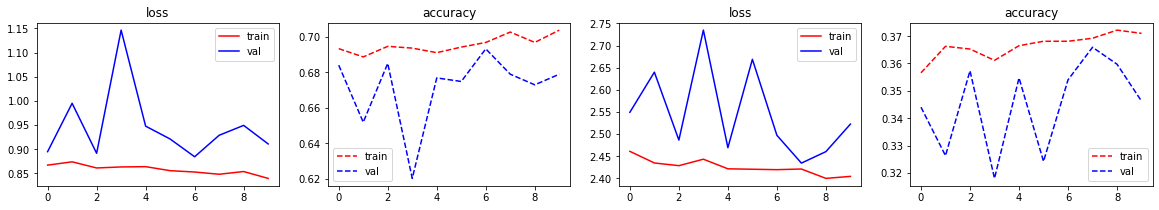

In [36]:
# A2. build network
# A2. model compile
model.compile(optimizer='adam',
              loss=['categorical_crossentropy', 'categorical_crossentropy'], # output이 2개이기 때문에 각각에 대해 loss를 지정해주어야 합니다.
              metrics=['accuracy', 'accuracy']) # output이 2개이기 때문에 각각에 대해 metric을 지정해주어야 합니다.
# A2. model train
history = model.fit_generator(datagen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              validation_data=test_datagen,
                              validation_steps=100, verbose=1)
# A2. training curve visualization
plot_history(history)